# Run filters on the folded targets

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_crispies
running on node: dig72


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Filter the binders

In [3]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "05_filter_binders"
design_list_file = os.path.join(
    os.getcwd(), "projects/crispy_crispies/04_fold_threaded_targets/folded_binders.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
options = " ".join(
    [
        "out:level 300",
    ]
)

gen_array_tasks(
    distribute_func="projects.crispy_crispies.deployables.filter_binder",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="4G",
    nstruct=1,
    nstruct_per_task=100,
    options=options,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-1654 /mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/run.sh


### Collect scorefiles of the filtered binders

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "05_filter_binders"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html
https://conda.io/activation



### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration

In [7]:
print(len(scores_df))
print(list(scores_df.columns))

165372
['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'chA_seq', 'cms', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'count_apolar', 'ddg', 'designed_by', 'docked_helix', 'dslf_fa13', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fa_atr', 'fa_dun', 'fa_elec', 'fa_intra_rep', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'geometry_parent', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'holes_all_parent', 'holes_core_parent', 'insertion_dG', 'kept_end', 'kept_start', 'lk_ball_wtd', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'omega', 'pTMscore', 'p_aa_pp', 'packstat_parent', 'parent', 'parent_length', 'pa

In [8]:
scores_df["count_cys"] = scores_df["chA_seq"].str.count("C")
scores_df["count_cys"].values

array([3, 4, 1, ..., 1, 3, 3])

In [9]:
inter = scores_df.query("ddg < -1000")
# ddg is very negative for disulfide bonds lol

non_inter = scores_df[~scores_df.index.isin(inter.index)]

### Get a set to order that form a cross interface disulfide against APOE

In [10]:
to_order = scores_df.query(
    "ddg < -1000 and insertion_dG > 3.5 and count_cys == 1 and cms > 350"
)
len(to_order)

72

### Dump a list of the order

In [11]:
with open(os.path.join(output_path, "apoe.list"), "w") as f:
    for decoy in to_order.index:
        print(decoy, file=f)

### Add ID column

In [12]:
ids = [f"apoe_{str(i).zfill(3)}" for i in range(1, 72 + 1)]
to_order["id"] = ids
to_order["id"]

/scratch/pleung/51527476/ipykernel_2505233/2229501735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_order["id"] = ids


/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0146/05_filter_binders_6a11fd7d5172485ea36b0e8b98b44a49.pdb.bz2    apoe_001
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0131/05_filter_binders_731ae80850074b0987b00899f277808a.pdb.bz2    apoe_002
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0041/05_filter_binders_00e8e6b011ca4d80bde016bb2da5128f.pdb.bz2    apoe_003
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0073/05_filter_binders_2595df65d12c49fc9a8329489155c4a8.pdb.bz2    apoe_004
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0004/05_filter_binders_aff8f3c276a74e1a8288fda12372f706.pdb.bz2    apoe_005
                                                                                                                                                   ...   
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoy

### Dump PDBs and FASTAs

In [13]:
import shutil

simulation_name = "05_filter_binders"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)
with open(os.path.join(output_path, "20220815_order.fasta"), "w") as f:
    for i, r in tqdm(to_order.iterrows(), total=to_order.shape[0]):
        print(f">{r.id}", file=f)
        print(f"{r.chA_seq}", file=f)
        shutil.copy(i, os.path.join(pdbs_path, f"{r.id}.pdb.bz2"))

  0%|          | 0/72 [00:00<?, ?it/s]

### Get a set to order that are really good for NPY

In [10]:
to_order = scores_df.query(
    "target_name == 'NPY_9-35' and ddg < -25 and insertion_dG > 3.5 and count_cys == 0 and cms > 350"
)
len(to_order)

33

### Dump a list of the order

In [15]:
with open(os.path.join(output_path, "npy.list"), "a") as f:
    for decoy in to_order.index:
        print(decoy, file=f)

### Add ID column

In [16]:
ids = [f"npy_{str(i).zfill(3)}" for i in range(1, 33 + 1)]
to_order["id"] = ids
to_order["id"]

/scratch/pleung/51527476/ipykernel_2505233/2159511061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_order["id"] = ids


/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0036/05_filter_binders_37ea3a2cfb9340d48ca6f0c93b235c70.pdb.bz2    npy_001
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0103/05_filter_binders_d8c396aa69fc426ca6487b3d805561f4.pdb.bz2    npy_002
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0004/05_filter_binders_24d2fcdac2e9473a8b7274155dc555dd.pdb.bz2    npy_003
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0025/05_filter_binders_b5cea93ddd5446b88b6a5e94d3669527.pdb.bz2    npy_004
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0052/05_filter_binders_b030f64e828b4f2cbf4180866abc023a.pdb.bz2    npy_005
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0010/05_filter_binders_f9c48a622490455b9c213af9493a7944.pdb.bz2    npy_006
/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0089

### Dump PDBs and FASTAs

In [18]:
import shutil

simulation_name = "05_filter_binders"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)
with open(os.path.join(output_path, "20220819_order.fasta"), "w") as f:
    for i, r in tqdm(to_order.iterrows(), total=to_order.shape[0]):
        print(f">{r.id}", file=f)
        print(f"{r.chA_seq}", file=f)
        shutil.copy(i, os.path.join(pdbs_path, f"{r.id}.pdb.bz2"))

  0%|          | 0/33 [00:00<?, ?it/s]

### Label binders that worked

In [11]:
worked = [
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0121/05_filter_binders_8785a0b65b9c451e9000f4810b75e011.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0026/05_filter_binders_11da136729044b61b8fb3a6e9da704c0.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0000/05_filter_binders_db07451e726342b8b450950a60fd08d1.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0002/05_filter_binders_f333fe9afa2d4600b931356fd381508e.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0029/05_filter_binders_3109818fbe8147909c73e719642983e5.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/05_filter_binders/decoys/0001/05_filter_binders_debbb051a67b43878ed83c4da63b372d.pdb.bz2",
]

good = to_order.loc[worked]
bad = pd.merge(to_order, good, how="outer", indicator=True)
bad = bad[bad._merge == "left_only"].drop("_merge", axis=1)
good["worked"] = True
bad["worked"] = False
sample_df = pd.concat([good, bad])

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [12]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

33
['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'chA_seq', 'cms', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'count_apolar', 'ddg', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'insertion_dG', 'kept_end', 'kept_start', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'prefix', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score', 'score_

In [13]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot before and after interface design AF2 metrics

22it [00:01, 17.99it/s]


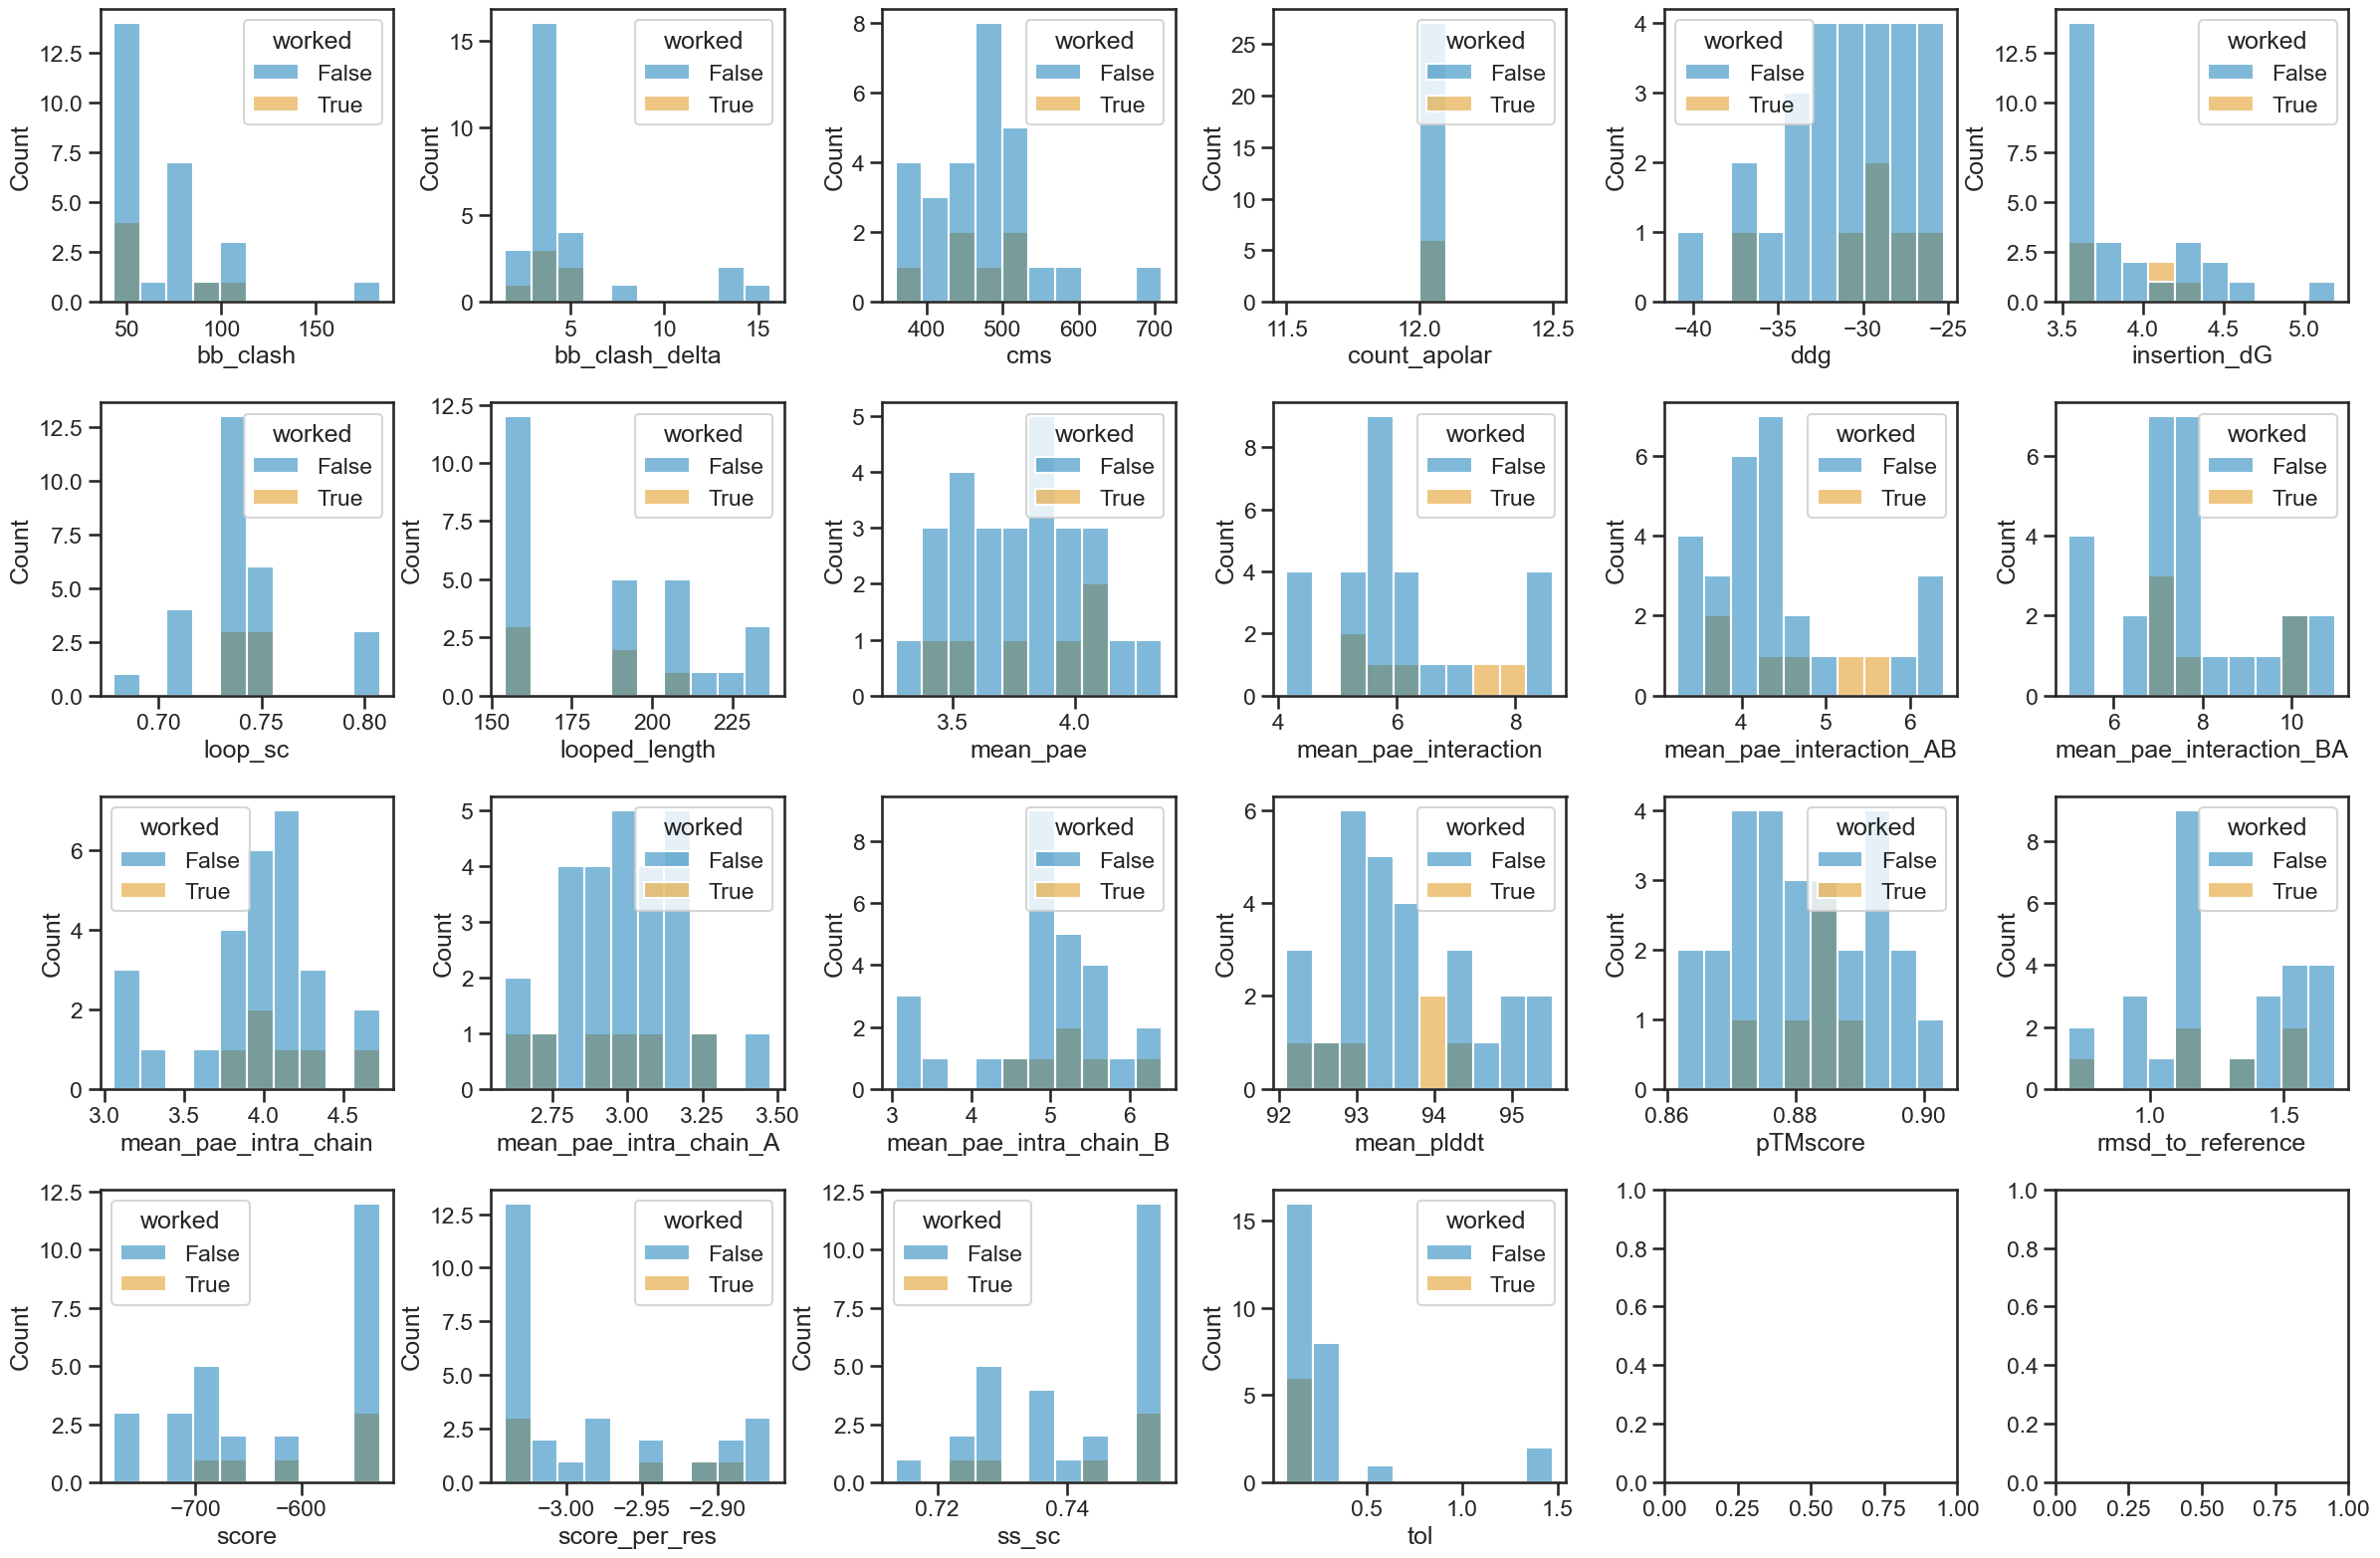

In [14]:
cols = [
    "bb_clash",
    "bb_clash_delta",
    "cms",
    "count_apolar",
    "ddg",
    "insertion_dG",
    "loop_sc",
    "looped_length",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
    "score",
    "score_per_res",
    "ss_sc",
    "tol",
]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="worked",
)
plt.savefig(os.path.join(output_path, "metrics.png"))

### Filter everything else for redesign

In [30]:
filtered_1 = scores_df.query(
    "(target_name == 'APOE' or target_name == 'NPY_9-35') and cms > 350 and ddg < -10 and insertion_dG > 0 and trimmed_length < 220"
)
len(filtered_1)

5889

In [31]:
filtered_2 = scores_df.query(
    "target_name != 'APOE' and target_name != 'NPY_9-35' and trimmed_length < 220"
)
len(filtered_2)

13101

In [32]:
filtered = pd.concat([filtered_1, filtered_2])
len(filtered)

18990

### Save a list of outputs
Sort by length

In [34]:
simulation_name = "05_filter_binders"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

with open(os.path.join(output_path, "filtered.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/18990 [00:00<?, ?it/s]